In [37]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [38]:
def readData(path):
    p = []
    with open(path, "r") as f:
        start = False
        for l in f:
            if "EOF" in l:
                break
            p.append(list(map(float, l.split(" "))))
    return p

In [39]:
dj38_data = readData(f"./data/dj38.tsp")
qa194_data = readData(f"./data/qa194.tsp")

In [42]:
def get_dis(x, y):
    return ((x[1] - y[1]) ** 2 + (x[2] - y[2]) ** 2) ** (1/2)

def cost_seq(seq):
    cost = 0
    sz = len(seq)
    for i in range(sz):
        cost += get_dis(seq[i], seq[(i + 1) % sz])
    return cost

def get_random_neighbor(seq):
    x = random.randint(1, len(seq) - 1)
    y = random.randint(1, len(seq) - 1)
    seq[x], seq[y] = seq[y], seq[x]
    return seq

def get_all_neighbor(seq):
    n = []
    for i in range(len(seq)):
        for j in range(0, i):
            temp = list(seq)
            temp[i], temp[j] = temp[j], temp[i]
            n.append(temp)
    return n

def get_random_neighbors(seq, n):
    s = len(seq)
    if s * (s - 1) // 2 <= n:
        return get_all_neighbor(seq)
    neighbors = []
    for i in range(n):
        neighbors.append(get_random_neighbor(seq))
    return neighbors

In [48]:
def hill_climbing(s_seq, max_it=10000, n_neighbors=150):
    cur_node = s_seq
    cur_cost = cost_seq(cur_node)
    cost_logs = []
    for i in range(max_it):
        neighbors = get_random_neighbors(cur_node, n_neighbors)
        next_node = None
        next_cost = float(1e10)
        for neighbor in neighbors:
            if cost_seq(neighbor) < next_cost:
                next_node = neighbor
                next_cost = cost_seq(neighbor)
        if next_cost < cur_cost:
            cur_cost = next_cost
            cur_node = next_node
        cost_logs.append(cur_cost)
    return cur_node, cost_logs

In [59]:
def simulated_annealing(s_seq, max_it=15000):
    cur_node = s_seq
    cur_cost = cost_seq(cur_node)
    cost_logs = []
    for i in range(1, max_it):
        random_neighbor = get_random_neighbor(cur_node)
        d = cost_seq(random_neighbor) - cur_cost
        if d > 0: 
            cur_node = random_neighbor
            cur_cost = cost_seq(random_neighbor)
        elif random.random() <= 1 / (i * 2):
            cur_node = random_neighbor
            cur_cost = cost_seq(random_neighbor)
        cost_logs.append(cur_cost)
    return cur_node, cost_logs

In [50]:
def create_population(seq, n_population):
  population = []
  logs = []
  for i in range(n_population):
      random.shuffle(seq)
      population.append(seq)
      logs.append([cost_seq(seq), seq])
  logs = sorted(logs)
  return population, logs

def select_elights(logs, n_elite):
  elite_population = []
  for i in range(n_elite):
        elite_population.append(logs[i])
  logs = logs[:n_elite]
  population = []
  for x in elite_population:
      population.append(x[1])
  return population, logs

def good_population(population):
  next_p = []
  for i in range(len(population)):
      for j in range(0, i):
          s = random.randint(0, len(population[i]))
          e = random.randint(0, len(population[i]))
          s, e = min(s, e), max(s, e)
          child = []
          for x in range(s, e):
              child.append(population[i][x])
          child += [x for x in population[j] if x not in child]
          next_p.append(child)
  return next_p

def make_better_generation(next_generation, mutation_rate):
  for i in range(len(next_generation)):
    for j in range(len(next_generation[i])):
        if random.random() > mutation_rate: continue
        k = random.randint(0, len(next_generation[i]) - 1)
        next_generation[i][j], next_generation[i][k] = next_generation[i][k], next_generation[i][j]
  return next_generation

def genetic(seq, n_population=1500, n_elite=100, mutation_rate=0.1, it=15000):
    best_seq = None
    best_cost = float(1e10)
    cost_logs = []
    population, progress = create_population(seq, n_population)
    if progress[0][0] < best_cost:
        best_seq = progress[0][1]
        best_cost = progress[0][0]
    cost_logs.append(best_cost)
    for i in range(it):
        population, progress = select_elights(progress, n_elite)
        next_generation = good_population(population)
        next_generation = make_better_generation(next_generation, mutation_rate)
        population = next_generation
        progress = []
        for x in population:
            progress.append([compute_cost(x), x])
        progress = sorted(progress)
        if progress[0][0] < best_cost:
            best_seq = progress[0][1]
            best_cost = progress[0][0]
        cost_logs.append(best_cost)
    return best_seq, cost_logs

#### tests for dj38_data

##### hill climbing

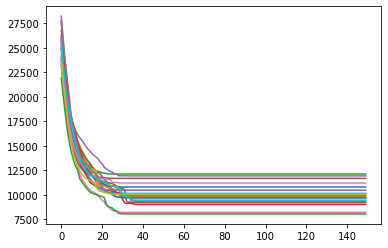

In [53]:
best_ans = None
best_cost = float(1e10)
for i in range(20):
    random.shuffle(dj38_data)
    ans, logs = hill_climbing(dj38_data, 150, 10000)
    plt.plot(logs)
    if cost_seq(path) < best_cost:
        best_cost = cost_seq(path)
        best_ans = ans

19727.566794958628


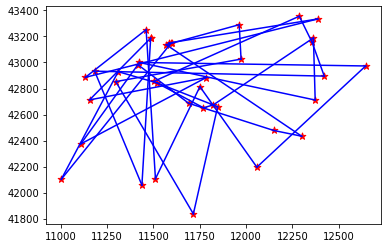

In [63]:
best_ans.append(best_ans[0])
print(best_cost)
for i in range(len(best_ans) - 1):
    plt.plot([best_ans[i][1], best_ans[i + 1][1]], [best_ans[i][2], best_ans[i + 1][2]], c="blue")
    plt.scatter([best_ans[i][1]], [best_ans[i][2]], c="red", marker="*", s=50)

##### simulated annealing

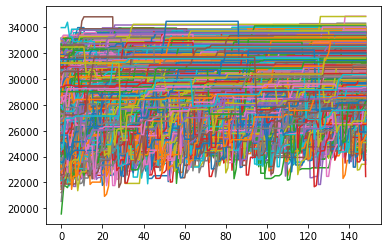

In [60]:
best_ans = None
best_cost = float(1e10)
for i in range(15000):
    random.shuffle(dj38_data)
    ans, logs = simulated_annealing(dj38_data, 150)
    plt.plot(logs)
    if cost_seq(ans) < best_cost:
        best_cost = cost_seq(ans)
        best_ans= ans

19727.566794958628


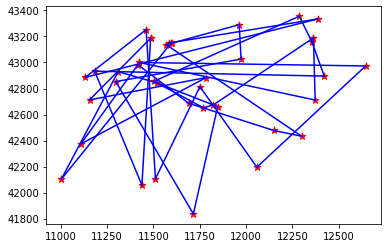

In [62]:
best_ans.append(best_ans[0])
print(best_cost)
for i in range(len(best_ans) - 1):
    plt.plot([best_ans[i][1], best_ans[i + 1][1]], [best_ans[i][2], best_ans[i + 1][2]], c="blue")
    plt.scatter([best_ans[i][1]], [best_ans[i][2]], c="red", marker="*", s=50)

##### genetic

In [65]:
ans, logs = genetic(dj38_data, it=1000)

7816.638534270056


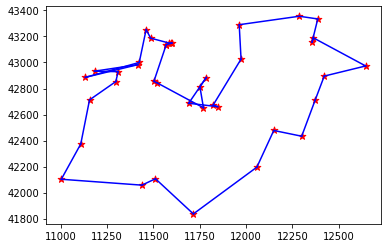

In [67]:
ans.append(ans[0])
print(logs[-1])
for i in range(len(ans) - 1):
    plt.plot([ans[i][1], ans[i + 1][1]], [ans[i][2], ans[i + 1][2]], c="blue")
    plt.scatter([ans[i][1]], [ans[i][2]], c="red", marker="*", s=50)

#### tests for qa194_data

##### hill climbing

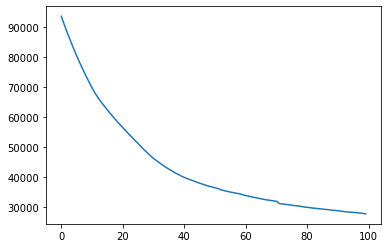

In [68]:
best_ans = None
best_cost = float(1e10)
for _ in range(1):
    random.shuffle(qa194_data)
    ans, logs = hill_climbing(qa194_data, 100, 1000000)
    plt.plot(logs)
    if cost_seq(ans) < best_cost:
        best_cost = cost_seq(ans)
        best_ans = ans

27583.641953800303


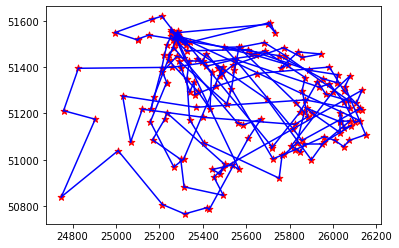

In [69]:
best_ans.append(best_ans[0])
print(best_cost)
for i in range(len(best_ans) - 1):
    plt.plot([best_ans[i][1], best_ans[i + 1][1]], [best_ans[i][2], best_ans[i + 1][2]], c="blue")
    plt.scatter([best_ans[i][1]], [best_ans[i][2]], c="red", marker="*", s=50)

##### simulated annealing

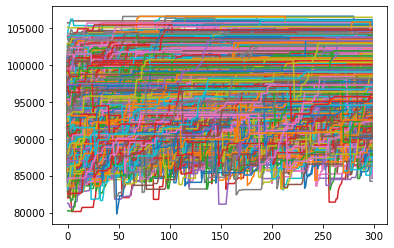

In [70]:
best_ans = None
best_cost = float(1e10)
for _ in range(15000):
    random.shuffle(qa194_data)
    ans, logs = simulated_annealing(qa194_data, 300)
    plt.plot(logs)
    if cost_seq(ans) < best_cost:
        best_cost = cost_seq(ans)
        best_ans = ans

80371.17985722372


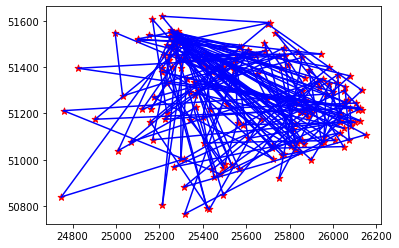

In [71]:
best_ans.append(best_ans[0])
print(best_cost)
for i in range(len(best_ans) - 1):
    plt.plot([best_ans[i][1], best_ans[i + 1][1]], [best_ans[i][2], best_ans[i + 1][2]], c="blue")
    plt.scatter([best_ans[i][1]], [best_ans[i][2]], c="red", marker="*", s=50)

#### genetic

In [72]:
ans, logs = genetic(qa194_data, it=4000, n_population=1500, n_elite=50, mutation_rate=0.1)

67297.87314251684


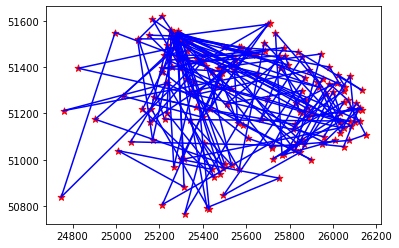

In [73]:
ans.append(ans[0])
print(logs[-1])
for i in range(len(ans) - 1):
    plt.plot([ans[i][1], ans[i + 1][1]], [ans[i][2], ans[i + 1][2]], c="blue")
    plt.scatter([ans[i][1]], [ans[i][2]], c="red", marker="*", s=50)